## GBT models training / Final Model Evaluations / Final Model Explanations

Sections:
- Imports
- Training GBT models
- ROC AUC comparisong GBT vs LSTM (best NN)
- Final ROC Plots
    - Validation set AUC ROC
    - Test set AUC ROC
- Optimise Threshold for savings/costs
- Dalex/SHAP explanations
- Calculate loss/savings


### Imports

In [3]:
import os
import pandas as pd
import numpy as np
import random
import math
import re
import sys
import pickle
from tqdm import tqdm
import warnings

# PyTorch
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn.functional as F
from torchmetrics.functional.regression import symmetric_mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader

# Optuna
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from packaging import version

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# Scipy
from scipy.interpolate import interp1d

# Visualization
import seaborn as sn
sn.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from datetime import datetime
import plotly.figure_factory as ff
import shap

device = 'cpu'

### Training GBT models

In [ ]:
# First trained without ICULOS
import catboost
import xgboost
import lightgbm
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Define y_train and drop label from features
y_train = X_train['SepsisLabel']
X_train = X_train.drop(columns=['SepsisLabel'])

# Define a custom scorer for AUC
auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)

# Define expanded hyperparameter grids for each model
catboost_param_grid = {
    'iterations': [100, 200, 300, 500],
    'learning_rate': [0.1, 0.05, 0.01, 0.001],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0.5, 1.0, 1.5],
    'border_count': [32, 64, 128]
}

xgboost_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.001],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'min_child_weight': [1, 3, 5],
}

lightgbm_param_grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.001],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'min_child_samples': [10, 20, 30],
}

print("Performing hyperparameter tuning for CatBoost...")
# Perform hyperparameter tuning for CatBoost
catboost_random_search = RandomizedSearchCV(
    catboost.CatBoostClassifier(scale_pos_weight=8),
    catboost_param_grid,
    scoring=auc_scorer,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_iter=10,
    random_state=42,
    n_jobs=-1,
    verbose=4
)
catboost_random_search.fit(X_train, y_train)

best_catboost_model = catboost_random_search.best_estimator_

print("Performing hyperparameter tuning for XGBoost...")
# Perform hyperparameter tuning for XGBoost
xgboost_random_search = RandomizedSearchCV(
    xgboost.XGBClassifier(scale_pos_weight=8),
    xgboost_param_grid,
    scoring=auc_scorer,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_iter=10,
    random_state=42,
    n_jobs=-1,
    verbose=4
)
xgboost_random_search.fit(X_train, y_train)

best_xgboost_model = xgboost_random_search.best_estimator_

print("Performing hyperparameter tuning for LightGBM...")
# Perform hyperparameter tuning for LightGBM
lightgbm_random_search = RandomizedSearchCV(
    lightgbm.LGBMClassifier(scale_pos_weight=8),
    lightgbm_param_grid,
    scoring=auc_scorer,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_iter=10,
    random_state=42,
    n_jobs=-1,
    verbose=4
)
lightgbm_random_search.fit(X_train, y_train)

best_lightgbm_model = lightgbm_random_search.best_estimator_



# Print cross-validated AUC scores for each model
print("Cross-validated AUC scores:")
print(f"CatBoost: {catboost_random_search.best_score_:.4f}")
print(f"XGBoost: {xgboost_random_search.best_score_:.4f}")
print(f"LightGBM: {lightgbm_random_search.best_score_:.4f}")

# Evaluate the best models on the validation set
val_auc_catboost = roc_auc_score(y_val, best_catboost_model.predict_proba(X_val)[:, 1])
val_auc_xgboost = roc_auc_score(y_val, best_xgboost_model.predict_proba(X_val)[:, 1])
val_auc_lightgbm = roc_auc_score(y_val, best_lightgbm_model.predict_proba(X_val)[:, 1])

# # Print AUC scores on the validation set
print("\nAUC scores on the validation set:")
print(f"CatBoost: {val_auc_catboost:.4f}")
print(f"XGBoost: {val_auc_xgboost:.4f}")
print(f"LightGBM: {val_auc_lightgbm:.4f}")

In [213]:
# Print cross-validated AUC scores for each model
print("Cross-validated AUC scores:")
print(f"CatBoost: {catboost_random_search.best_score_:.4f}")
print(f"XGBoost: {xgboost_random_search.best_score_:.4f}")
print(f"LightGBM: {lightgbm_random_search.best_score_:.4f}")

Cross-validated AUC scores:
CatBoost: 0.7864
XGBoost: 0.8054
LightGBM: 0.7868


In [ ]:
val_xgboost_predictions = []
val_catboost_predictions = []
val_lightgbm_predictions = [] 
val_labels = []
with torch.no_grad():
        for data1 in dataloader1.val_dataloader():
            
                inputs1, labels = data1
                inputs2, _ = data1
            
                # Forward pass through base models
                outputs_xgb = torch.Tensor(best_xgboost_model.predict_proba(inputs2[:,-1, :].detach().numpy())[:, 1]).unsqueeze(1)
                outputs_cat = torch.Tensor(best_catboost_model.predict_proba(inputs2[:,-1, :].detach().numpy())[:, 1]).unsqueeze(1)
                outputs_lgbm = torch.Tensor(best_lightgbm_model.predict_proba(inputs2[:,-1, :].detach().numpy())[:, 1]).unsqueeze(1)

                # Collect predictions and labels for validation set
                val_xgboost_predictions.extend(outputs_xgb.detach().numpy())
                val_catboost_predictions.extend(outputs_cat.detach().numpy())
                val_lightgbm_predictions.extend(outputs_lgbm.detach().numpy())
                val_labels.extend(labels.cpu().numpy()) 

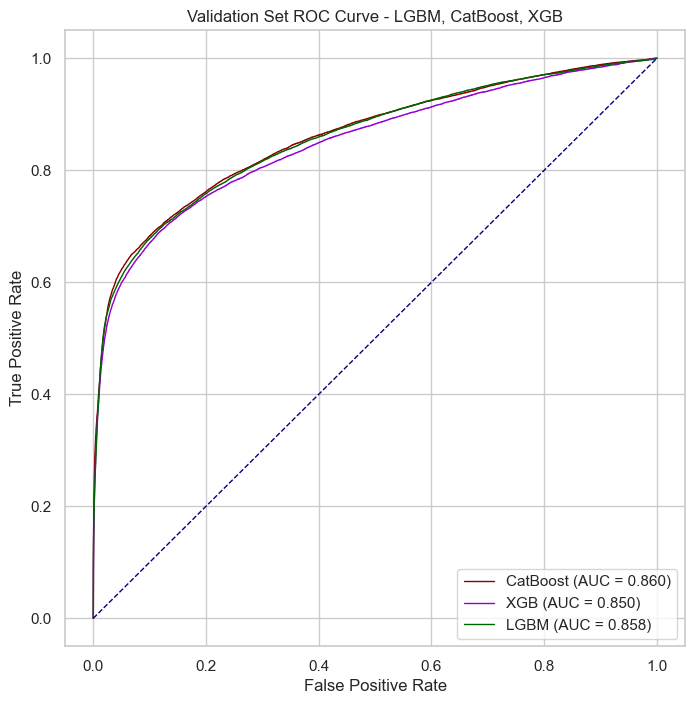

In [150]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calculate ROC curve for lgbm
fpr_lgbm, tpr_lgbm, thresholds = roc_curve(val_labels, val_lightgbm_predictions)
roc_auc_lgbm = roc_auc_score(val_labels, val_lightgbm_predictions)


# Calculate ROC curve for cat
fpr_cat, tpr_cat, thresholds = roc_curve(val_labels, val_catboost_predictions)
roc_auc_cat = roc_auc_score(val_labels, val_catboost_predictions)

# Calculate ROC curve for xgb
fpr_xgb, tpr_xgb, thresholds = roc_curve(val_labels, val_xgboost_predictions)
roc_auc_xgb = roc_auc_score(val_labels, val_xgboost_predictions)

# Visualize ROC curve
plt.figure(figsize=(8, 8))

plt.plot(fpr_cat, tpr_cat, color='darkred', lw=1, label=f'CatBoost (AUC = {roc_auc_cat:.3f})')
plt.plot(fpr_xgb, tpr_xgb, color='darkviolet', lw=1, label=f'XGB (AUC = {roc_auc_xgb:.3f})')
plt.plot(fpr_lgbm, tpr_lgbm, lw=1, label=f'LGBM (AUC = {roc_auc_lgbm:.3f})', color = 'darkgreen')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Set ROC Curve - LGBM, CatBoost, XGB')
plt.legend(loc='lower right')
plt.show()

In [152]:
# Export best model (CatBoost)

import pickle

with open('models_nn_all/sepsis_cat.pkl', 'wb') as f:
    pickle.dump(best_catboost_model, f)

### ROC AUC comparison (LSTM vs GBT)

In [153]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, in_size, h_size, num_l, out_f, dropout_rate, activ):
        super().__init__()
        self.input_size = in_size
        self.hidden_size = h_size
        self.num_layers = num_l
        self.out_features = out_f
        self.dropout_rate = dropout_rate
        self.activ = activ
        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True,
                            dropout=self.dropout_rate
                            )
        self.linear1 = nn.Linear(in_features=self.hidden_size,
                                 out_features=self.out_features)

    def forward(self, X):
        X, _ = self.lstm(X)
        # Picking the last output
        X = self.activ(X[:,-1,:])
        X = self.linear1(X)

        return X
    
    

In [154]:
import lightgbm
import pickle

# Import best boosting model for clinical measurements (catboost  )
with open('models_nn_all/sepsis_cat.pkl', 'rb') as f:
    best_catboost_model = pickle.load(f)

# Import best NN model capturing time effect (lstm)
with open('models_nn_all/sepsis_lstm.pkl', 'rb') as f:
    best_lstm_model = pickle.load(f)

In [ ]:
# Results on Validation Set

val_lstm_predictions = []
val_catboost_predictions = [] 
val_labels = []
with torch.no_grad():
        for data1 in dataloader1.val_dataloader():
            
                inputs1, labels = data1
                inputs2, _ = data1
            
                # Forward pass through base models
                outputs1 = torch.sigmoid(best_lstm_model(inputs1).squeeze())
                outputs2 = torch.Tensor(best_catboost_model.predict_proba(inputs2[:,-1, :].detach().numpy())[:, 1]).unsqueeze(1)
             
                val_lstm_predictions.extend(outputs1.detach().numpy())
                val_catboost_predictions.extend(outputs2.detach().numpy())
                val_labels.extend(labels.cpu().numpy()) 

In [ ]:
# Results on Test Set

test_lstm_predictions = []
test_catboost_predictions = [] 
test_labels = []
with torch.no_grad():
        for data1 in dataloader1.test_dataloader():
            
                inputs1, labels = data1
                inputs2, _ = data1
            
                # Forward pass through base models
                outputs1 = torch.sigmoid(best_lstm_model(inputs1).squeeze())
                outputs2 = torch.Tensor(best_catboost_model.predict_proba(inputs2[:,-1, :].detach().numpy())[:, 1]).unsqueeze(1)
                
                # Forward pass through meta-model
                # meta_outputs = meta_model(outputs1, outputs2)

                # Collect predictions and labels for validation set
                # val_meta_predictions.extend(meta_outputs.sigmoid().cpu().numpy())
                test_lstm_predictions.extend(outputs1.detach().numpy())
                test_catboost_predictions.extend(outputs2.detach().numpy())
                test_labels.extend(labels.cpu().numpy()) 

### Final ROC plots

Validation Set AUC ROC

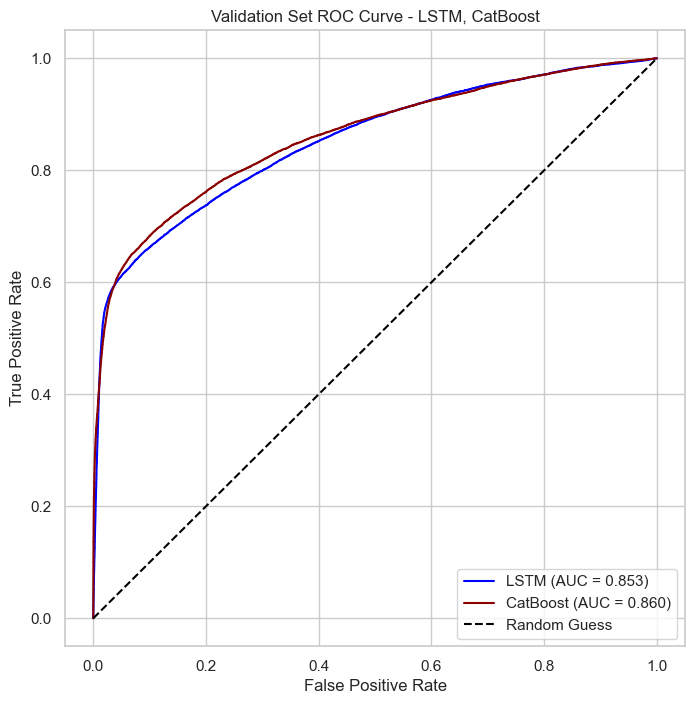

AUC for best_lstm_model: 0.853
AUC for CatBoost: 0.860


In [179]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Create a bigger figure
plt.figure(figsize=(8, 8))

# Calculate ROC curve and AUC for best_lstm_model
fpr_lstm, tpr_lstm, _ = roc_curve(val_labels, val_lstm_predictions)  # Assuming the positive class is at index 0
auc_lstm = roc_auc_score(val_labels, val_lstm_predictions)
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.3f})', color = 'blue')

# Calculate ROC curve and AUC for best_catboost_model
fpr_catboost, tpr_catboost, _ = roc_curve(val_labels, val_catboost_predictions)  # Assuming the positive class is at index 1
auc_catboost = roc_auc_score(val_labels, val_catboost_predictions)
plt.plot(fpr_catboost, tpr_catboost, label=f'CatBoost (AUC = {auc_catboost:.3f})', color = 'darkred')

# Plot ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Set ROC Curve - LSTM, CatBoost')
plt.legend(loc='lower right')
plt.show()

print(f'AUC for best_lstm_model: {auc_lstm:.3f}')
print(f'AUC for CatBoost: {auc_catboost:.3f}')

Test Set AUC ROC


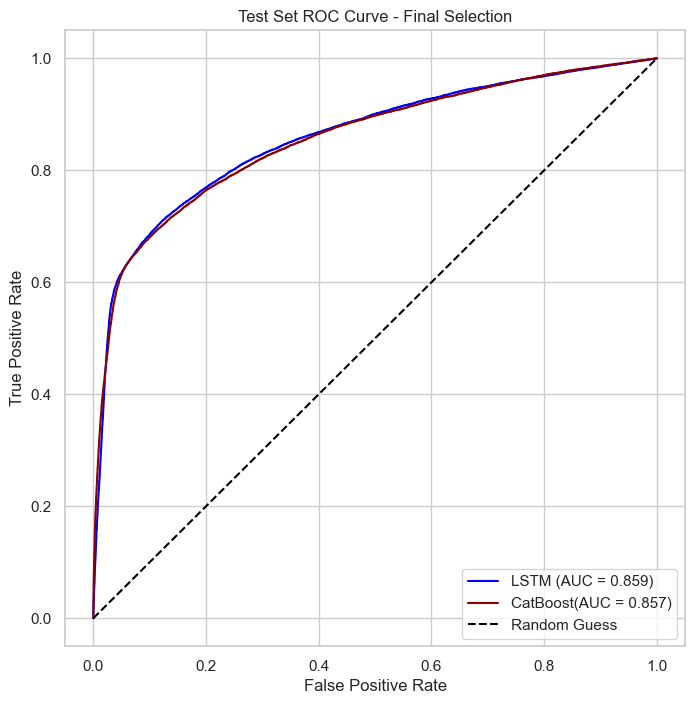

AUC for best_lstm_model: 0.8589
AUC for CatBoost time: 0.8567


In [159]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Create a bigger figure
plt.figure(figsize=(8, 8))

# Calculate ROC curve and AUC for best_lstm_model
fpr_lstm, tpr_lstm, _ = roc_curve(test_labels, test_lstm_predictions)  # Assuming the positive class is at index 0
auc_lstm = roc_auc_score(test_labels, test_lstm_predictions)
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {auc_lstm:.3f})', color = 'blue')

# Calculate ROC curve and AUC for best_catboost_model
fpr_catboost, tpr_catboost, _ = roc_curve(test_labels, test_catboost_predictions)  # Assuming the positive class is at index 1
auc_catboost = roc_auc_score(test_labels, test_catboost_predictions)
plt.plot(fpr_catboost, tpr_catboost, label=f'CatBoost(AUC = {auc_catboost:.3f})', color = 'darkred')

# Plot ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curve - Final Selection')
plt.legend(loc='lower right')
plt.show()

print(f'AUC for best_lstm_model: {auc_lstm:.4f}')
print(f'AUC for CatBoost time: {auc_catboost:.4f}')

### Optimise threshold for savings/costs

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import dataloader_wrapper_cuda
import importlib

your_module = importlib.reload(dataloader_wrapper_cuda)

dataloader_org = dataloader_wrapper_cuda.SepsisDataLoader(train_dir="data/all/all_processed_sepsis_df_hours_before_onset.csv",
                          seq_len=20,
                          X_scaler=scaler,
                          X_imputer=imputer,
                          test_size=0.3,
                          random_state=42,
                          batch_size=256,
                          training_size=1,
                          num_workers=6,
                          device=device
                          )
dataloader_org.prepare_for_training()

val_lstm_predictions = []
val_catboost_predictions = [] 
val_labels = []
original_labels = []
with torch.no_grad():
        for (data1, data2) in zip(dataloader1.val_dataloader(), dataloader_org.val_dataloader()):
            
                inputs1, labels = data1
                inputs2, _ = data1
                org_labels, _ = data2
                # Forward pass through base models
                outputs1 = torch.sigmoid(best_lstm_model(inputs1).squeeze())
                outputs2 = torch.Tensor(best_catboost_model.predict_proba(inputs2[:,-1, :].detach().numpy())[:, 1]).unsqueeze(1)
                
                # Forward pass through meta-model
                # meta_outputs = meta_model(outputs1, outputs2)

                # Collect predictions and labels for val set
                # val_meta_predictions.extend(meta_outputs.sigmoid().cpu().numpy())
                val_lstm_predictions.extend(outputs1.detach().numpy())
                val_catboost_predictions.extend(outputs2.detach().numpy())
                val_labels.extend(labels.cpu().numpy())
                original_labels.extend(org_labels[:,-1, :].cpu().numpy())

train val test id nums 28234 6051 6051
uniq filepaths, len filepaths 40336 1552210
flag0 (1087188, 5) (233589, 5) (231433, 5)


100%|██████████| 6051/6051 [00:08<00:00, 716.52it/s]


In [177]:
test_labels_lstm_predictions = []
test_catboost_predictions = [] 
test_labels = []
test_original_labels = []
with torch.no_grad():
        for (data1, data2) in zip(dataloader1.test_dataloader(), dataloader_org.test_dataloader()):
            
                inputs1, labels = data1
                inputs2, _ = data1
                org_labels, _ = data2
                # Forward pass through base models
                outputs1 = torch.sigmoid(best_lstm_model(inputs1).squeeze())
                outputs2 = torch.Tensor(best_catboost_model.predict_proba(inputs2[:,-1, :].detach().numpy())[:, 1]).unsqueeze(1)
                
                # Forward pass through meta-model
                # meta_outputs = meta_model(outputs1, outputs2)

                # Collect predictions and labels for test set
                test_lstm_predictions.extend(outputs1.detach().numpy())
                test_catboost_predictions.extend(outputs2.detach().numpy())
                test_labels.extend(labels.cpu().numpy())
                test_original_labels.extend(org_labels[:,-1, :].cpu().numpy())

In [ ]:
recoded_labels = val_labels

In [164]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

def optimize_threshold_balanced_accuracy(y_true, y_pred_prob):
    # Initialize variables to store best threshold and associated balanced accuracy
    best_threshold = 0.5
    max_balanced_accuracy = 0
    
    # Iterate over thresholds from 0 to 1 with step size 0.01
    for threshold in np.arange(0, 1.01, 0.01):
        # Convert hour_effectabilities to binary predictions based on threshold
        y_pred = (y_pred_prob >= threshold).astype(int)
        
        # Calculate balanced accuracy for the current threshold
        balanced_acc = balanced_accuracy_score(y_true, y_pred)
        
        # Update best threshold if the balanced accuracy is higher
        if balanced_acc > max_balanced_accuracy:
            max_balanced_accuracy = balanced_acc
            best_threshold = threshold
    
    return best_threshold, max_balanced_accuracy

def calculate_savings(predictions, original_labels, recoded_labels, hour_effect=0.02):
    # hour_effect is an effect of either an hour earlier detection or an hour extended treatment for not-septic patient (simpliefied)
    # Initialize the sum to keep track of the Savings savings or losses
    total_savings = 0
    
    # Iterate through each prediction, original label, and recoded label
    for pred, orig, recoded in zip(predictions, original_labels, recoded_labels):

        # Check the conditions and update the total_savings accordingly
        if pred == 1 and orig == 0 and recoded == 1:
            total_savings += 40 * hour_effect  # Add to sum (60 * hour_effect)
        elif pred == 1 and orig == 0 and recoded == 0:
            total_savings -= 12 * hour_effect  # Subtract from sum (12 * hour_effect)
        else:
            pass  # No change in the probability of loss as clinical diagnosis is lagging as well, or clinicans already diagnosed
        # For other cases, do nothing
    
    return total_savings


def optimize_threshold(y_true, y_pred_prob, Savings_fp=12, Savings_fn=60):
    # Initialize variables to store best threshold and associated Savings
    best_threshold = 0.5
    max_savings = float(0)
    
    # Iterate over thresholds from 0 to 1 with step size 0.01
    for threshold in np.arange(0, 1.01, 0.01):
        y_labels = [int(p>threshold) for p in y_pred_prob]
        # Calculate Savings for the current threshold
        savings = calculate_savings(y_labels, original_labels,  y_true)
        
        # Update best threshold if the Savings is lower
        if savings > max_savings:
            max_savings = savings
            best_threshold = threshold
    
    # Calculate Savings for threshold 0.5
    y_labels_0_5 = [int(p>0.5) for p in y_pred_prob]
    savings_at_0_5 = calculate_savings(y_labels_0_5, original_labels, y_true)
    
    # Calculate the false negative rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_true, [int(p>best_threshold) for p in y_pred_prob]).ravel()
    fnr_at_cost = fn / (fn + tp)
    
    return best_threshold, max_savings, fnr_at_cost, savings_at_0_5

In [165]:

# Example usage for 3 models
models_data = [
    ("Best LSTM", (np.array(recoded_labels), np.array(val_lstm_predictions))),
    ("Best Catbosot", (np.array(recoded_labels), np.array(val_catboost_predictions))), 
]

results = []

for model_name, (targets, preds) in models_data:
    best_threshold, max_savings, fnr, savings_at_0_5 = optimize_threshold(targets, preds)
    best_threshold_balanced_acc, max_balanced_accuracy = optimize_threshold_balanced_accuracy(targets, preds)
    
    results.append({
        "Model": model_name,
        "Best Threshold": best_threshold,
        "Savings at Threshold": max_savings,
        "Savings at Threshold 0.5": savings_at_0_5,
        "FNR at Threshold": fnr,
        "Best Threshold for Balanced Accuracy": best_threshold_balanced_acc,
        "Max Balanced Accuracy": max_balanced_accuracy
    })

# Create DataFrame from the results
results_df = pd.DataFrame(results)

# Print the DataFrame
results_df

C:\Users\JanFrackowiak\AppData\Local\Temp\ipykernel_11124\3447293678.py:50: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\JanFrackowiak\AppData\Local\Temp\ipykernel_11124\3447293678.py:60: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\JanFrackowiak\AppData\Local\Temp\ipykernel_11124\3447293678.py:64: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



,Model,Best Threshold,Savings at Threshold,Savings at Threshold 0.5,FNR at Threshold,Best Threshold for Balanced Accuracy,Max Balanced Accuracy
0,Best LSTM,0.73,6741.92,4269.60,0.409999,0.63,0.782182
1,Best Catbosot,0.84,6837.28,3931.52,0.382938,0.70,0.791416


In [13]:
results_df[['Model',	'Best Threshold',	'Savings at Threshold',	'Savings at Threshold 0.5']].to_latex(float_format="%.2f")

'\\begin{tabular}{llrrr}\n\\toprule\n & Model & Best Threshold & Savings at Threshold & Savings at Threshold 0.5 \\\\\n\\midrule\n0 & Best LSTM & 0.73 & 6732.80 & 4302.88 \\\\\n1 & Best Catbosot & 0.76 & 6934.32 & 5637.04 \\\\\n\\bottomrule\n\\end{tabular}\n'

### Dalex & SHAP explanations

In [166]:
cols = dataloader1.columns_to_keep


def dataloader_to_dataframe(loader, colnames):
    data_list = []
    y_list = []
    for batch, y in tqdm(loader):
        # Unroll the batch data and target tensor
        batch_data = batch.numpy()[:,-1,:]  # Convert tensors to numpy arrays
        y_data = y.numpy()
        data_list.append(batch_data)
        y_list.append(y_data)

    # Concatenate data and target lists
    data_array = np.concatenate(data_list)
    y_array = np.concatenate(y_list)

    # Reshape data to unroll the first dimension
    data_array = data_array.reshape(-1, *data_array.shape[1:])

    # Convert to pandas DataFrame
    df = pd.DataFrame(data_array, columns=colnames)
    return df, y_array

# Convert validation DataLoader to DataFrame
X_val, y_val = dataloader_to_dataframe(dataloader1.val_dataloader(), cols)

100%|██████████| 472/472 [00:33<00:00, 13.96it/s]


In [167]:
from dalex import Explainer

# Assuming you have already trained a model called 'model' and have your data stored in 'X_train' and 'y_train'
X_val_ex = X_val
# Identify rows where all elements are zero
all_zero_rows = (X_val_ex == 0).all(axis=1)

# Option 1: Using boolean indexing to filter out these rows
X_val_ex = X_val_ex.loc[~all_zero_rows]

# Create an explainer object
exp = Explainer(best_catboost_model, X_val_ex, np.array(recoded_labels))

# Calculate and plot variable importance
variable_importance = exp.model_parts()
variable_importance.plot()

# Select two variables for partial dependence plots
selected_variables = ['ICULOS', 'EtCO2','Age', 'Resp_diff', 'O2Sat', 'FiO2']  # Replace 'var1' and 'var2' with the names of your selected variables

# Generate partial dependence plots
# pdp_iculos = exp.model_profile(type='partial', variables=['ICULOS'])
# pdp_iculos.plot()
for elem in selected_variables:
    pdp_etco2 = exp.model_profile(type='partial', variables=elem)
    pdp_etco2.plot()

Preparation of a new explainer is initiated

  -> data              : 120736 rows 51 cols
  -> target variable   : 120736 values
  -> model_class       : catboost.core.CatBoostClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x00000125F1FA2020> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.019, mean = 0.46, max = 0.996
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.991, mean = -0.305, max = 0.934
  -> model_info        : package catboost

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 1/1 [00:00<00:00, 62.59it/s]
c:\Users\JanFrackowiak\anaconda3\envs\dl-env\Lib\site-packages\dalex\model_explanations\_aggregated_profiles\utils.py:144: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.02089552 0.03068657 0.04047761 ... 0.98041791 0.99020896 1.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



Calculating ceteris paribus: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s]
c:\Users\JanFrackowiak\anaconda3\envs\dl-env\Lib\site-packages\dalex\model_explanations\_aggregated_profiles\utils.py:144: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.10647058 0.11122515 0.11597972 ... 0.57241846 0.57717303 0.5819276 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



Calculating ceteris paribus: 100%|██████████| 1/1 [00:00<00:00, 64.52it/s]
c:\Users\JanFrackowiak\anaconda3\envs\dl-env\Lib\site-packages\dalex\model_explanations\_aggregated_profiles\utils.py:144: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.02325581 0.03302326 0.0427907  ... 0.98046512 0.99023256 1.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



Calculating ceteris paribus: 100%|██████████| 1/1 [00:00<00:00, 66.70it/s]
c:\Users\JanFrackowiak\anaconda3\envs\dl-env\Lib\site-packages\dalex\model_explanations\_aggregated_profiles\utils.py:144: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.05681818 0.06630682 0.07579546 ... 0.9867046  0.99619324 1.00568187]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



Calculating ceteris paribus: 100%|██████████| 1/1 [00:00<00:00, 62.47it/s]
c:\Users\JanFrackowiak\anaconda3\envs\dl-env\Lib\site-packages\dalex\model_explanations\_aggregated_profiles\utils.py:144: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.12174875 0.13029306 0.13883737 ... 0.95909098 0.96763529 0.9761796 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



Calculating ceteris paribus: 100%|██████████| 1/1 [00:00<00:00, 68.79it/s]
c:\Users\JanFrackowiak\anaconda3\envs\dl-env\Lib\site-packages\dalex\model_explanations\_aggregated_profiles\utils.py:144: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.00866667 0.01733333 ... 0.84933334 0.85800001 0.86666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [198]:
# Option 1: Using boolean indexing to filter out these rows
X_val_ex = X_val_ex.loc[~all_zero_rows]
X_val_ex['EtCO2'] = X_val_ex['EtCO2'].round(3)
etco2_mean = X_val_ex['EtCO2'].mean()
etco2_std = X_val_ex['EtCO2'].std()

# Uncomment for Calculating ETCO grouped profiles
X_val_ex['EtCO2'] = X_val_ex['EtCO2'].apply(lambda x: etco2_mean + 3*etco2_std if x > etco2_mean + etco2_std else etco2_mean - 3*etco2_std if x < etco2_mean - etco2_std  else etco2_mean)

# Create an explainer object
exp = Explainer(best_catboost_model, X_val_ex, np.array(recoded_labels))

Preparation of a new explainer is initiated

  -> data              : 120736 rows 51 cols
  -> target variable   : 120736 values
  -> model_class       : catboost.core.CatBoostClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x00000125F1FA2020> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0214, mean = 0.49, max = 0.995
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.993, mean = -0.336, max = 0.916
  -> model_info        : package catboost

A new explainer has been created!


In [199]:
pdp_etco2 = exp.model_profile(type='partial', variables='ICULOS', groups= 'EtCO2')
fig = pdp_etco2.plot(show=False)
fig = fig.for_each_trace(lambda t: t.update(name=t.name.replace(f'CatBoostClassifier_{etco2_mean}','CatBoostClassifier Mean EtCO2') \
                                                        .replace(f'CatBoostClassifier_{etco2_mean + 3*etco2_std}','CatBoostClassifier High EtCO2') \
                                                        .replace(f'CatBoostClassifier_{etco2_mean - 3*etco2_std}','CatBoostClassifier Low EtCO2')))
fig.show()
# X_val_ex['EtCO2'] = X_val_ex['EtCO2'].apply(lambda x: 0.25 if x > 0.235 else 0.2 if x < 0.215 else 0.22)

Calculating ceteris paribus: 100%|██████████| 1/1 [00:00<00:00, 55.52it/s]
c:\Users\JanFrackowiak\anaconda3\envs\dl-env\Lib\site-packages\dalex\model_explanations\_aggregated_profiles\utils.py:144: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.02089552 0.03068657 0.04047761 ... 0.98041791 0.99020896 1.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



Text(0.5, 1.0, 'Shapley Values on Validation Set (CatBoost)')

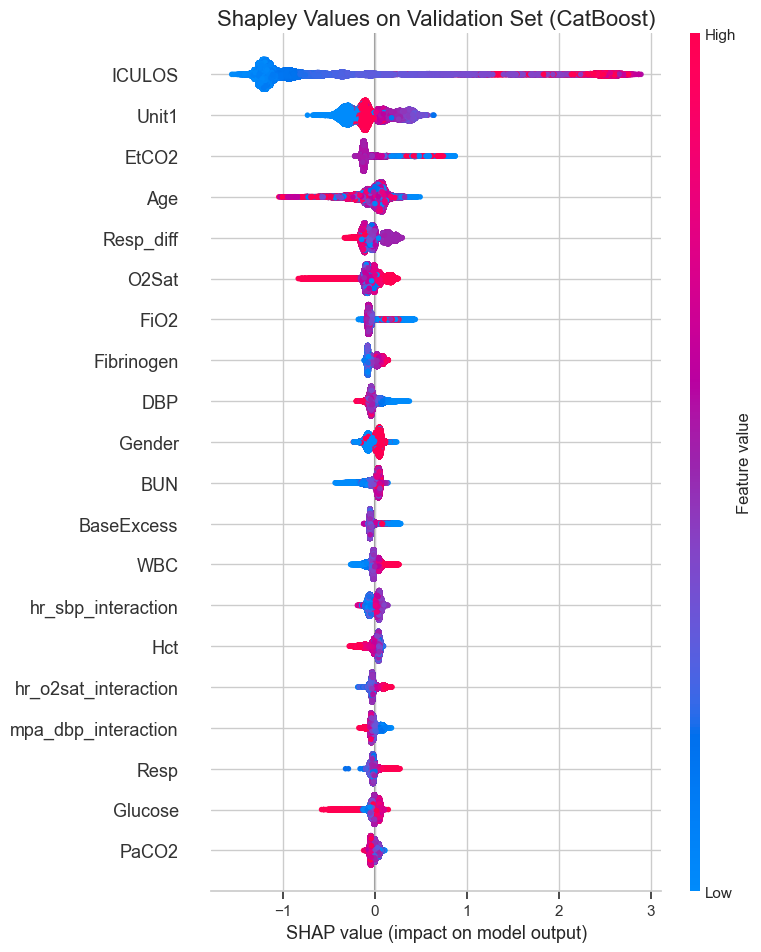

In [168]:
import shap 

# Create the SHAP explainer
explainer = shap.TreeExplainer(best_catboost_model)

# Calculate SHAP values for the sample data
# Assuming you have already trained a model called 'model' and have your data stored in 'X_train' and 'y_train'
X_val_ex = X_val
# Identify rows where all elements are zero
all_zero_rows = (X_val == 0).all(axis=1)

# Option 1: Using boolean indexing to filter out these rows
X_val_ex = X_val_ex.loc[~all_zero_rows]

# filtered_X_val_ex = X_val_ex[X_val_ex.iloc[:, 37] <= 0.021]
sample = X_val_ex
shap_values = explainer.shap_values(sample, check_additivity=False)
# print(shap_values.shape, sample_data_selected.numpy().shape)

# shap_values = np.sum(shap_values, axis=1)
# sample_data_selected = np.sum(sample_data_selected.numpy(), axis=1)

# Plot the SHAP values
feature_names = dataloader1.columns_to_keep
shap.summary_plot(shap_values, sample, feature_names=feature_names, show=False, title = "Shapley Values on validation sample (Catboost)")
plt.title("Shapley Values on Validation Set (CatBoost)", fontsize = 16)

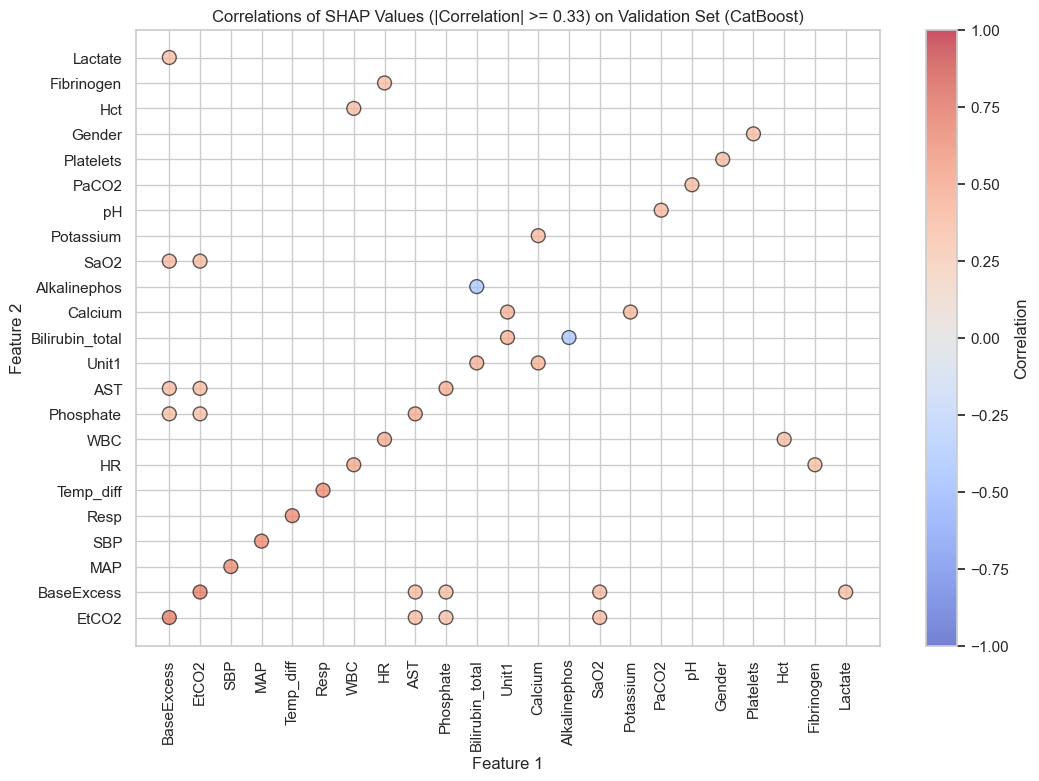

In [172]:
import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Convert SHAP values to a DataFrame
shap_df = pd.DataFrame(shap_values, columns=feature_names)

# Filter out features containing 'interaction'
filtered_features = [col for col in shap_df.columns if 'interaction' not in col]
shap_df = shap_df[filtered_features]

# Compute the correlation matrix
correlation_matrix = shap_df.corr()

# Apply the threshold filter (absolute value of 0.5)
threshold = 0.33
strong_correlations = correlation_matrix.stack().reset_index()
strong_correlations.columns = ['Feature1', 'Feature2', 'Correlation']
strong_correlations = strong_correlations[(strong_correlations['Correlation'].abs() >= threshold) & (strong_correlations['Feature1'] != strong_correlations['Feature2'])]

# Remove duplicate pairs by keeping the one with the highest absolute correlation value
strong_correlations['AbsCorrelation'] = strong_correlations['Correlation'].abs()
strong_correlations = strong_correlations.sort_values(by='AbsCorrelation', ascending=False).drop_duplicates(subset=['Feature1', 'Feature2'])

# Plot the scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(strong_correlations['Feature1'], strong_correlations['Feature2'], c=strong_correlations['Correlation'],
                      cmap='coolwarm', s=100, edgecolor='k', alpha=0.7, vmin=-1, vmax=1)
plt.colorbar(scatter, label='Correlation')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlations of SHAP Values (|Correlation| >= 0.33) on Validation Set (CatBoost)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
# Add annotation for the threshold
# plt.text(1.19, -0.045, '|Correlation| >= 0.33', fontsize=11, ha='right', va='bottom', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

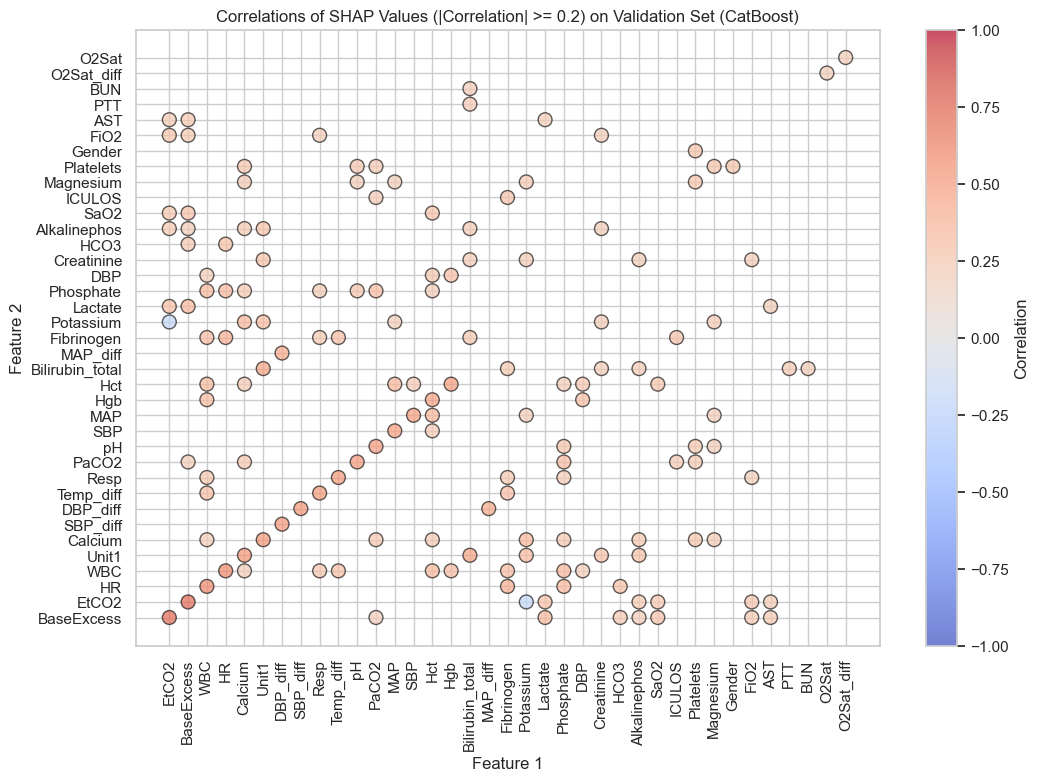

In [27]:
import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Convert SHAP values to a DataFrame
shap_df = pd.DataFrame(shap_values, columns=feature_names)

# Filter out features containing 'interaction'
filtered_features = [col for col in shap_df.columns if 'interaction' not in col]
shap_df = shap_df[filtered_features]

# Compute the correlation matrix
correlation_matrix = shap_df.corr()

# Apply the threshold filter (absolute value of 0.5)
threshold = 0.2
strong_correlations = correlation_matrix.stack().reset_index()
strong_correlations.columns = ['Feature1', 'Feature2', 'Correlation']
strong_correlations = strong_correlations[(strong_correlations['Correlation'].abs() >= threshold) & (strong_correlations['Feature1'] != strong_correlations['Feature2'])]

# Remove duplicate pairs by keeping the one with the highest absolute correlation value
strong_correlations['AbsCorrelation'] = strong_correlations['Correlation'].abs()
strong_correlations = strong_correlations.sort_values(by='AbsCorrelation', ascending=False).drop_duplicates(subset=['Feature1', 'Feature2'])

# Plot the scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(strong_correlations['Feature1'], strong_correlations['Feature2'], c=strong_correlations['Correlation'],
                      cmap='coolwarm', s=100, edgecolor='k', alpha=0.7, vmin=-1, vmax=1)
plt.colorbar(scatter, label='Correlation')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlations of SHAP Values (|Correlation| >= 0.2) on Validation Set (CatBoost)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
# Add annotation for the threshold
# plt.text(1.19, -0.045, '|Correlation| >= 0.33', fontsize=11, ha='right', va='bottom', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

In [ ]:
for i in range(1000):
    try:
        shap.dependence_plot(i, shap_values=shap_values, features=sample, feature_names=sample.columns, display_features=sample)
    except:
        pass

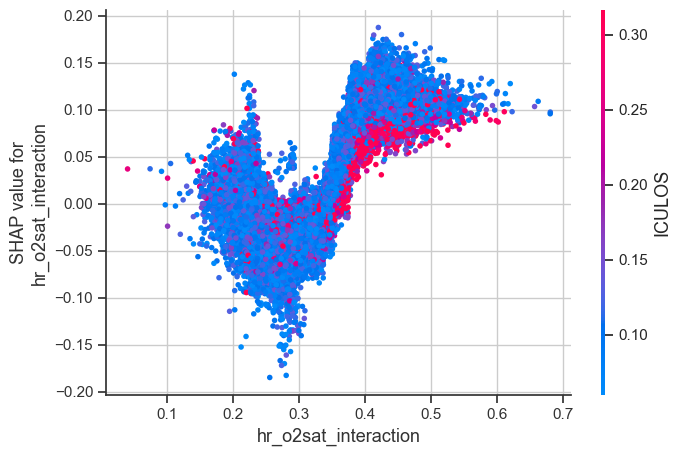

In [209]:
# shap_df = pd.DataFrame(shap_values, columns=cols)
# shap.plots.scatter(shap_df[:, 'hr_o2sat_interaction'], color=shap_df[:, 'ICULOS'])
shap.dependence_plot('hr_o2sat_interaction', shap_values, X_val, interaction_index='ICULOS')

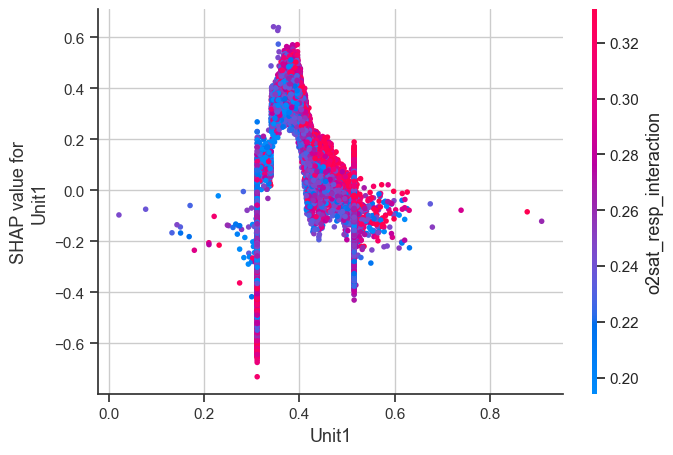

In [212]:
# shap_df = pd.DataFrame(shap_values, columns=cols)
# shap.plots.scatter(shap_df[:, 'hr_o2sat_interaction'], color=shap_df[:, 'ICULOS'])
shap.dependence_plot('Unit1', shap_values, X_val, interaction_index='o2sat_resp_interaction')

In [174]:
explainer.expected_value

0.7254411227436435

In [16]:
np.where(np.array(original_labels) ==1)

(array([   484,    485,    486, ..., 120168, 120169, 120170], dtype=int64),)

### Calculate loss/savings

Using functions already defined for threshold optimisations.
Savings estimated with different hour_effects

In [175]:
import pandas as pd

# Define the values of hour_effect to evaluate
hour_effects = [0.005, 0.01, 0.02, 0.05]

# Initialize lists to store results
results = []
# recoded_labels = test_labels
for hour_effect in hour_effects:
    total_savings_catboost = calculate_savings([int(p>0.84) for p in val_catboost_predictions], original_labels, recoded_labels, hour_effect)
    total_savings_lstm = calculate_savings([int(p>0.73) for p in val_lstm_predictions], original_labels, recoded_labels, hour_effect)
    # Append results to the list
    results.append({
        'Hour Effect': hour_effect,
        'Total Savings (CatBoost)': total_savings_catboost,
        'Total Savings (LSTM)': total_savings_lstm,
    })

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
results_df


C:\Users\JanFrackowiak\AppData\Local\Temp\ipykernel_11124\727241253.py:10: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



,Hour Effect,Total Savings (CatBoost),Total Savings (LSTM)
0,0.005,1709.32,1685.48
1,0.010,3418.64,3370.96
2,0.020,6837.28,6741.92
3,0.050,17093.20,16854.80


In [178]:
import pandas as pd

# Define the values of hour_effect to evaluate
hour_effects = [0.005, 0.01, 0.02, 0.05]

# Initialize lists to store results
results = []
# recoded_labels = test_labels
for hour_effect in hour_effects:
    total_savings_catboost = calculate_savings([int(p>0.84) for p in test_catboost_predictions], test_original_labels, test_labels, hour_effect)
    total_savings_lstm = calculate_savings([int(p>0.73) for p in test_lstm_predictions], test_original_labels, test_labels, hour_effect)
    # Append results to the list
    results.append({
        'Hour Effect': hour_effect,
        'Total Savings (CatBoost)': total_savings_catboost,
        'Total Savings (LSTM)': total_savings_lstm,
    })

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
results_df


C:\Users\JanFrackowiak\AppData\Local\Temp\ipykernel_11124\1822124038.py:10: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



,Hour Effect,Total Savings (CatBoost),Total Savings (LSTM)
0,0.005,1770.9,1767.66
1,0.010,3541.8,3535.32
2,0.020,7083.6,7070.64
3,0.050,17709.0,17676.60
